In [2]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel

In [3]:
seed = np.random.randint(0, 2025)
# seed = 25
np.random.seed(seed)
print(f'Seed: {seed}')
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)



# t = np.array([ 0.11727534, -0.38461938,  0.91559512])
# t = fn.unit_vec(t)
# p = np.array([-0.31832113,  0.85875371,  0.4015143 ])
# p = fn.unit_vec(p)



# ### NOTE FOR COMPARISON ###
# t, p = fn.i_hat, fn.k_hat
# t, p = fn.unit_vec(fn.i_hat + fn.j_hat), fn.unit_vec(fn.j_hat - fn.i_hat)
# t, p = fn.i_hat, fn.j_hat

Seed: 800


Original params:  [351.02421715  10.97559365 -10.8877346 ]


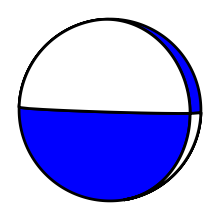

Takeoff angles: [45.74277419944782, 49.94361025435123]


In [4]:
#################################################################
# USE OBSPY TO PRODUCE BEACHBALLS FROM DIFFERENT INPUT PARAMETERS
# VERIFY CONSISTENCY FOR OUR vs OBSPY FUNCTIONS
#################################################################


# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)


# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
# model = TauPyModel(model='iasp...')
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
print(f"Takeoff angles: {takeoff_angles}")


true_hidden = fn.tp2hidden(t, p, azimuth, in_deg=True)


#############################################
# EXTRACT VELOCITIES FROM LOOKUP TABLE
#############################################
# look for them in TauPy, may not work
# use linear interpolation from Suzan's table
#############################################
velocities = np.array([5.8000, 3.4600])

In [5]:
importlib.reload(fn)
importlib.reload(rm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)

model_Ao = radiation_model(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters
config = opt.get_config()

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

# # systematic start for debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_starts = len(starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 98%


In [6]:
# this is a good tool for intersection!!!

params, error, position = radiation_model.get_optimal_parameters(z_threshold=2)
name = 'T' if position == 0 else 'P'

print(f'Constrained axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

# plots.half_angles(radiation_model, bins=10)

Constrained axis: T
Optimal parameters: [75.97797912 48.42775204  1.58900276]
Search error: 0.005144076561406518 degrees


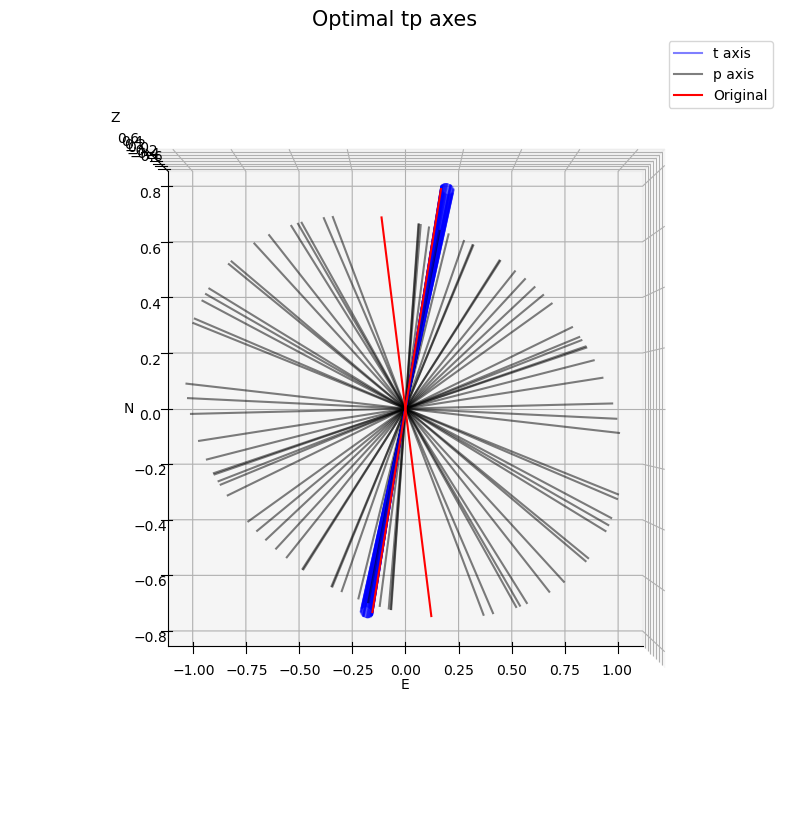

In [8]:
# optimal plot - tp space, collapse to central
importlib.reload(plots)
plots.tp_axes(radiation_model, azim=-90, elev=90, half=False)

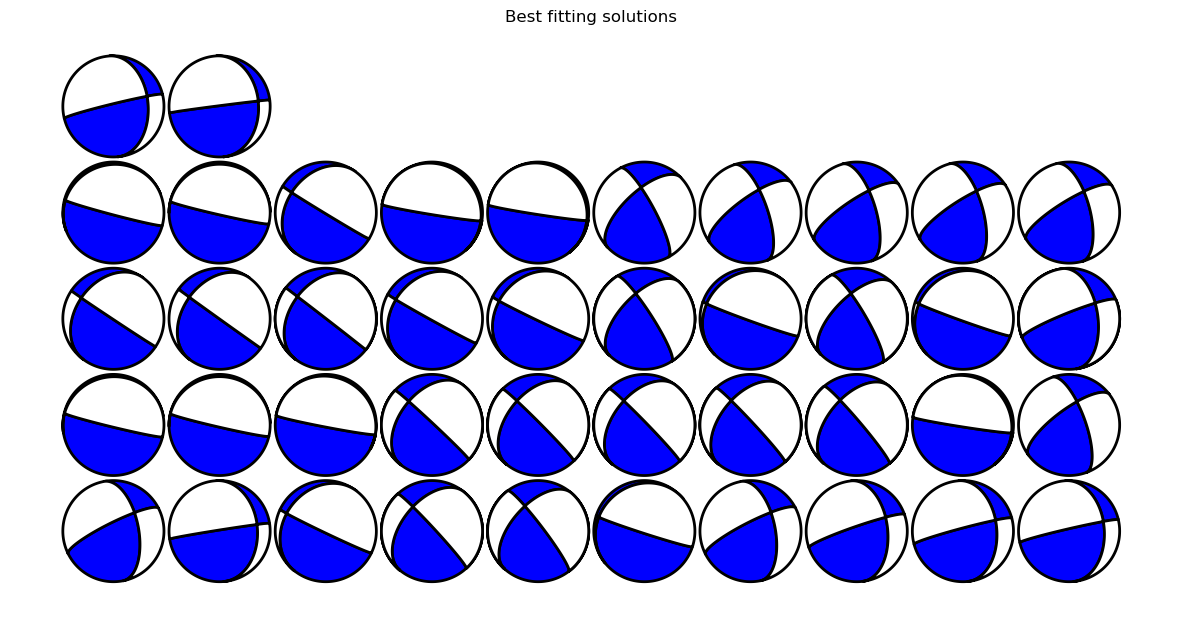

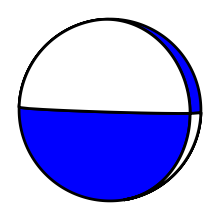

In [9]:
# beachball plots
importlib.reload(plots)
max_plot = max(num_starts, 100)
plots.beachballs(radiation_model, central=False, order_by='strike', max_plot=max_plot,
                 width=10, figsize=(15,10))
beachball

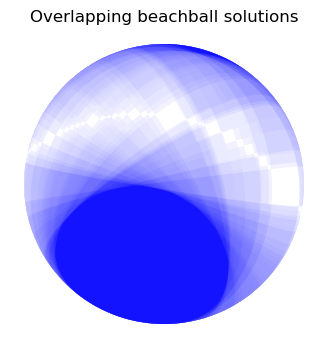

In [10]:
importlib.reload(plots)
plots.beachballs(radiation_model, central=False, order_by='strike', max_plot=max_plot,
                 width=10, figsize=(15,10), overlap=True)

In [284]:
print(f'Seed: {seed}')

Seed: 259
